<h4>Paso 1: Explorar la Data de la Serie de Tiempo</h4>

Establecer en R el directorio de trabajo en el que se descargaron los registros (<a href="https://drive.google.com/file/d/1e8XsB-3tcJUgiq_Upp7VQSRo2stjquO3/view?usp=sharing" target="_blank">canal.csv</a>) y cargar la data.</div>

In [1]:
setwd('C:/Mis documentos/trabajos/sistemas/Red Norte/Infraestructura/The Dude')
data = read.csv('canal.csv')

Ver la data cargada.

In [2]:
data

Consumo
266636404096
293493365541
259932652065
132261732615
128348485314
160120214917
135495436984
271399410091
263818612207
257733472823


Graficarla la data en Mb/s para lo cual se divide la data por 10800000000 el cual es el resultado de la ecuación (horas 24)*(minutos 60)*(segundos 60)*(bit 1000)*(Kb 1000)/(escala 8).

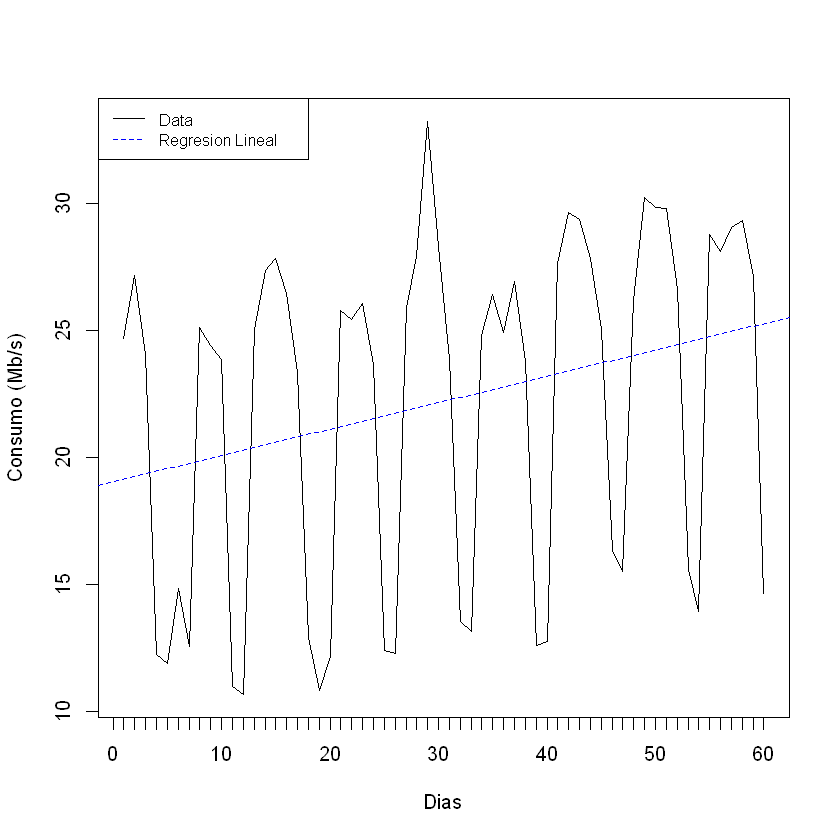

In [3]:
plot(data$Consumo/10800000000, type='l', xlab='Dias', ylab='Consumo (Mb/s)')
axis(side=1, at=c(1:60), labels=FALSE)
axis(side=1, at=c(1:60), labels=FALSE)
abline(lm(data$Consumo/10800000000~c(1:60)), lty=2, col='blue')
legend("topleft", legend=c("Data", "Regresion Lineal"), col=c("black", "blue"), lty=1:2, cex=0.8)

Analizando la gráfica se evidencian periodos estacionales de 7 días, es decir semanales y la regresión lineal muestra una tendencia ascendente en función del tiempo.
Teniendo en cuenta lo los periodos estacionales se almacena la data en una serie de tiempo de frecuencia 7.

In [4]:
datats = ts(data, start=c(1,1), frequency=7)

Generar la gráfica de la Media de Consumo del Canal por Semana.

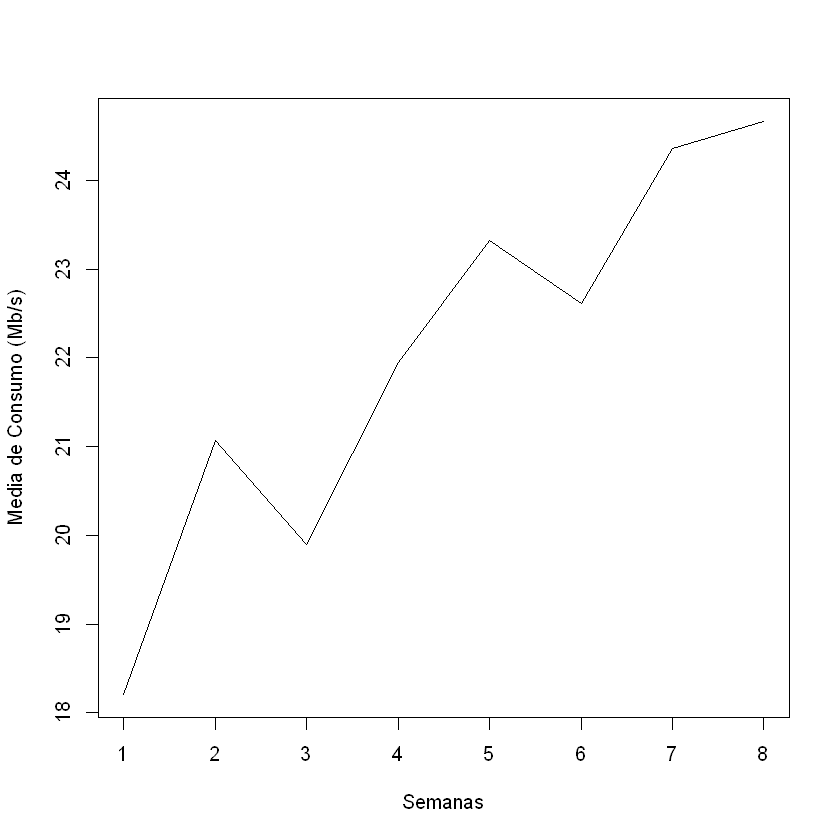

In [5]:
plot(aggregate(datats/10800000000,FUN=mean), xlab='Semanas', ylab='Media de Consumo (Mb/s)')

La gráfica evidencia que la media de consumo presenta una tendencia ascendente en función del tiempo.
Generar gráficos de caja y bigote por los días de la semana.

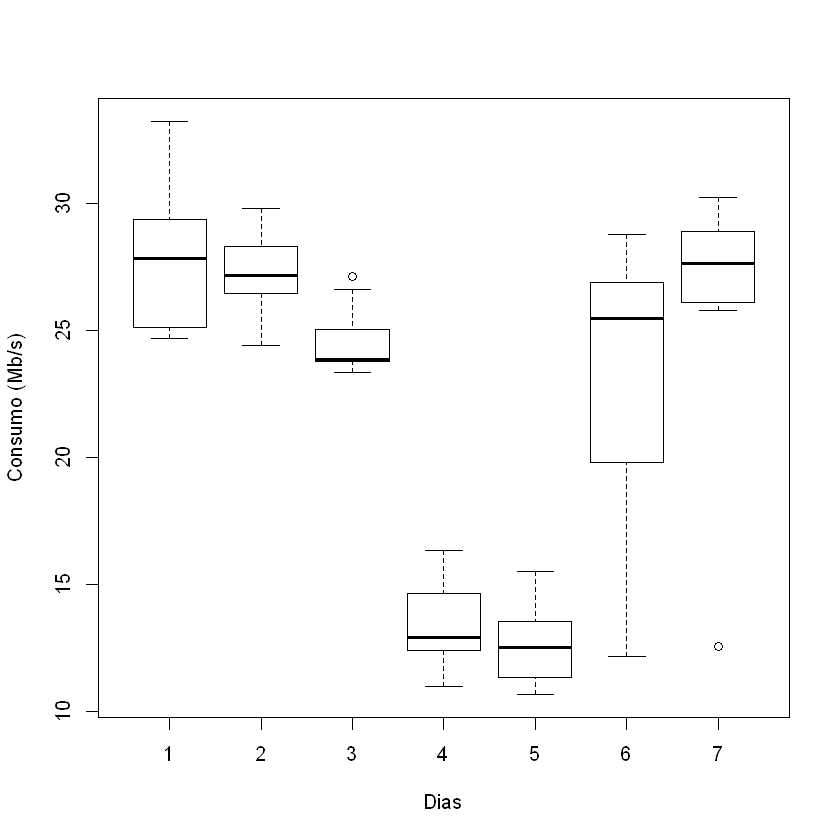

In [6]:
boxplot(datats/10800000000~cycle(datats), xlab='Dias', ylab='Consumo (Mb/s)')

La gráfica evidencia que la media de cada día es diferente, su varianza es corta y en los días 4 y 5 es muy inferior con respecto a los demás días por lo que se puede inferir que la serie de tiempo es fuertemente estacional en periodos semanales.

Generar la gráfica de los componentes de la serie de tiempo.

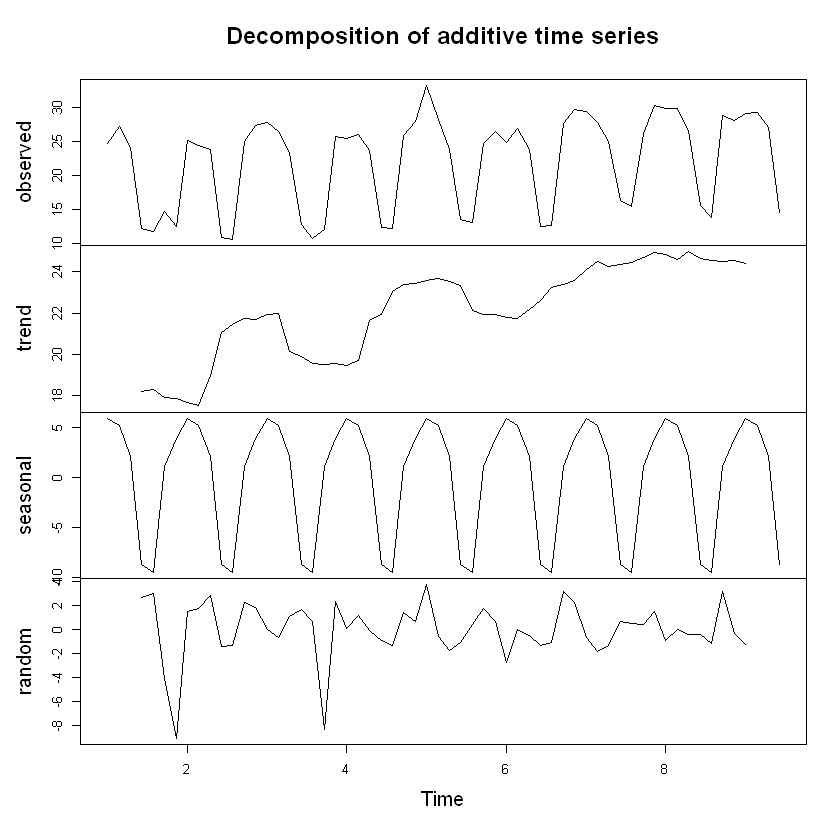

In [7]:
datatsdecom = decompose(datats/10800000000)
plot(datatsdecom)

Los gráficos generados en la exploración de la Data permiten inferir que la serie temporal es No Estacionaria ya que su media y su varianza varían en función del tiempo por lo que se debe transformarla para poder aplicarle algoritmos de predicción.

<h4>Paso 2: Estacionarizar la Serie de Tiempo</h4>

Generar gráfica de la Data aplicándole diferencia de orden 1 para ver la Data transformada en Estacionaria en Media (eliminar tendencia).

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


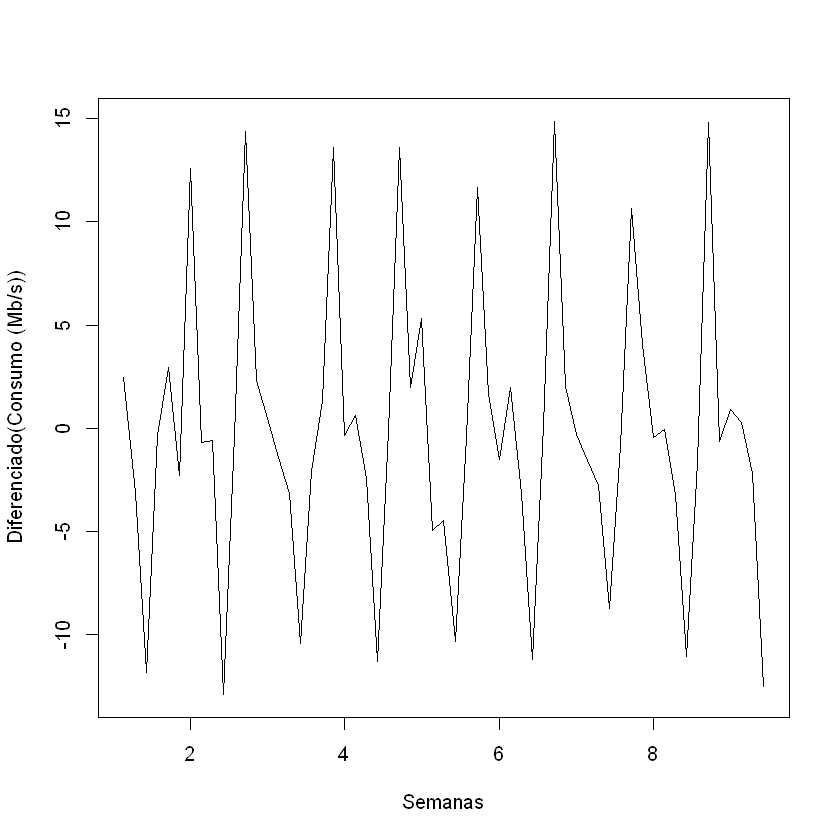

In [8]:
library(tseries)
plot(diff(datats/10800000000), xlab='Semanas', ylab='Diferenciado(Consumo (Mb/s))')

Generar gráfica de la Data aplicándole logaritmo para ver la Data transformada en Estacionaria en Varianza.

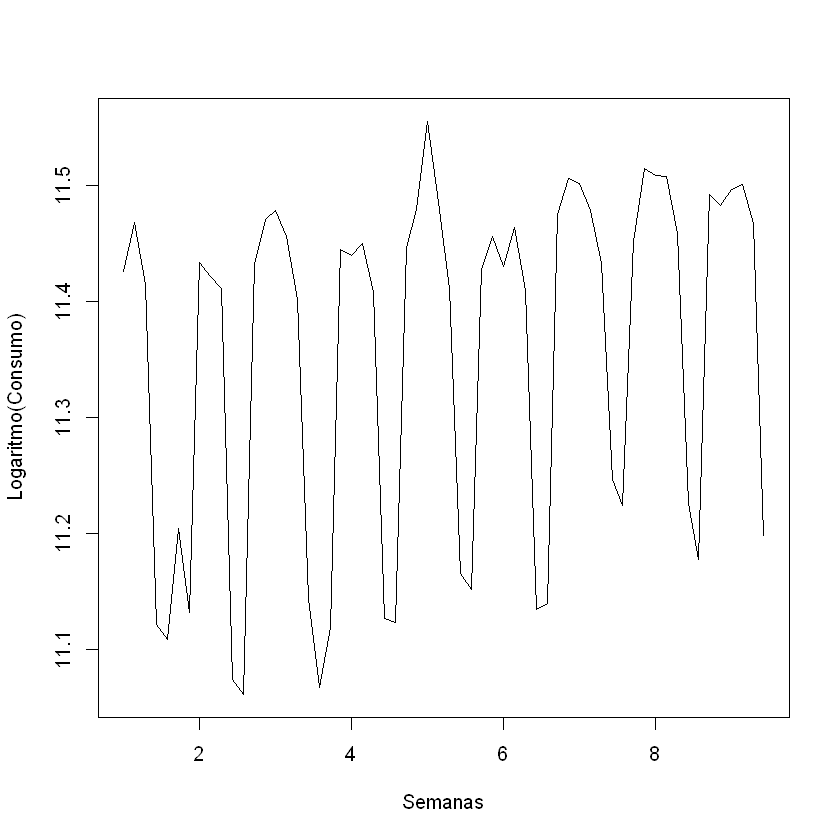

In [9]:
plot(log10(datats), xlab='Semanas', ylab='Logaritmo(Consumo)')

Generar gráfica de la Data aplicándole diferencia de orden 1 al logaritmo para ver la Data transformada en Estacionaria en Media y en Varianza.

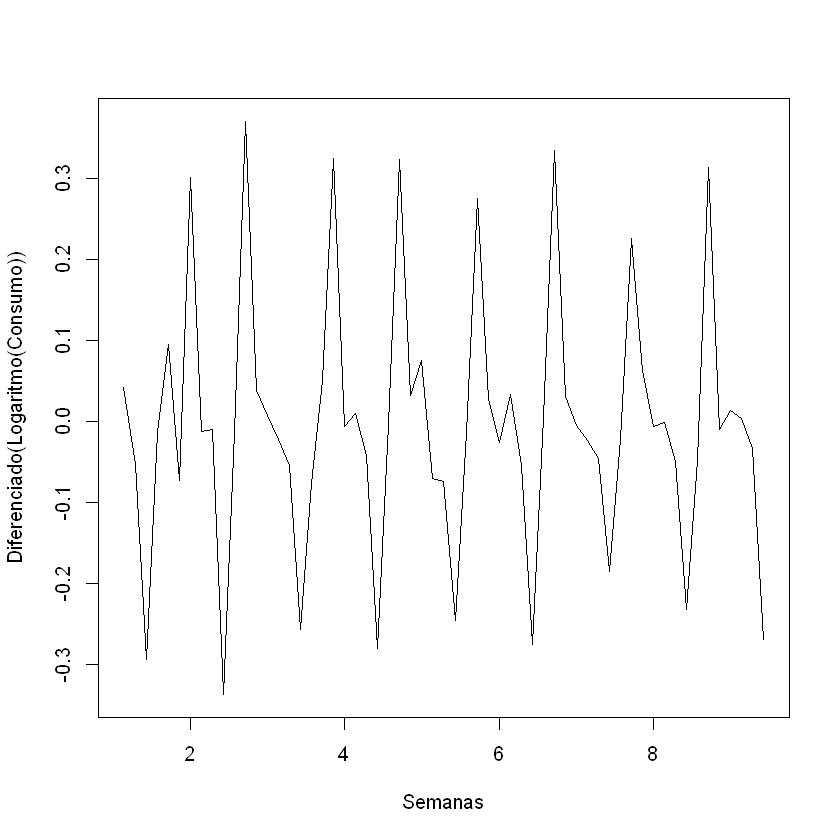

In [10]:
plot(diff(log10(datats)), xlab='Semanas', ylab='Diferenciado(Logaritmo(Consumo))')

Generar test de Estacionariedad de la Data transformada.

In [11]:
adf.test(diff(log10(datats)), alternative="stationary", k=0)

Warning message in adf.test(diff(log10(datats)), alternative = "stationary", k = 0):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  diff(log10(datats))
Dickey-Fuller = -6.4853, Lag order = 0, p-value = 0.01
alternative hypothesis: stationary


El resultado del test generó un p-valor menor a 0.05 por lo que no se rechaza la hipotesis de Estacionariedad de la Data transformada.

<h4>Paso 3: Estimación y Verificación</h4>

Generar las gráficas de ACF (Autocorrelación Simple) y PACF (Autocorrelación Parcial) para identificar los patrones en donde la Data transformada es Estacionaria en Media y en Varianza, por medio de identificar la presencia de componentes AR (Autoregresión) y MA (Media Móvil) en los residuales.

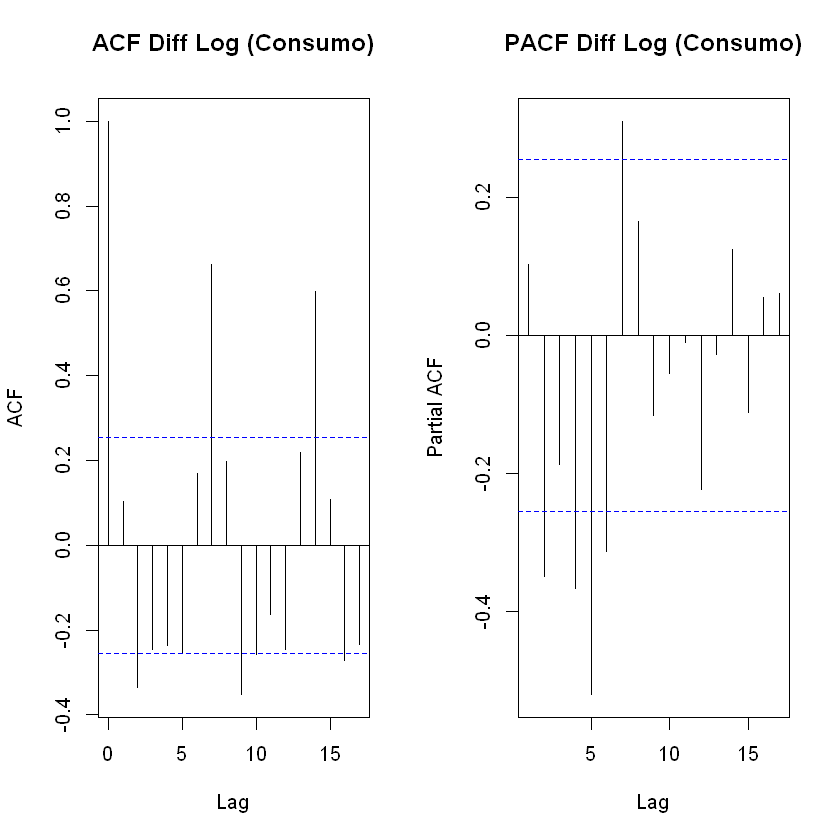

In [12]:
par(mfrow = c(1,2))
acf(ts(diff(log10(datats))), main='ACF Diff Log (Consumo)')
pacf(ts(diff(log10(datats))), main='PACF Diff Log (Consumo)')

ACF mide la correlación entre dos variables separadas por k periodos o Lag (retrasos). En la gráfica la barra del retraso 0 toma el valor 1 ya que los datos sin retraso son los mismos y están autocorrelacionados, en algunos retrasos la barra sale de la zona de insignificancia (linea punteada azul) lo que implica que los residuales no son aleatorios y todavía contienen información, adicionalmente en los retrasos 7 y 14 la barra muestra picos evidenciando componentes de estacionalidad.

PACF mide la correlación entre dos variables separadas por k periodos cuando no se considera la dependencia creada por los retardos intermedios existentes entre ambas. (Ver <a href="https://drive.google.com/file/d/1MMt9eN82QRzN1X3boRvMhWu0MRdqkDev/view?usp=sharing" target="_blank">Introducción a Series de Tiempo</a>).

Interpretando las barras que salen de la zona de insignificancia en ACF y en PACF se identifican los posibles parámetros que al aplicarlos en ARIMA generen el modelo más ajustado, es decir, aquel cuyos residuales sean aleatorios (ruido blanco).

La búsqueda de los parámetros para el mejor ajuste de ARIMA se puede automatizar con la función auto.arima() de la siguiente manera.

In [13]:
library(forecast)
ARIMAfit = auto.arima(log10(datats), approximation=FALSE, trace=FALSE)
summary(ARIMAfit)

Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff


Series: log10(datats) 
ARIMA(0,0,0)(1,1,1)[7] with drift 

Coefficients:
         sar1     sma1   drift
      -0.5730  -0.4205  0.0025
s.e.   0.1538   0.1954  0.0006

sigma^2 estimated as 0.004202:  log likelihood=67.88
AIC=-127.76   AICc=-126.93   BIC=-119.88

Training set error measures:
                      ME      RMSE        MAE        MPE     MAPE      MASE
Training set 0.003590528 0.0591736 0.03856933 0.03022437 0.339331 0.7145298
                 ACF1
Training set 0.134734


Generar test de ruido blanco.

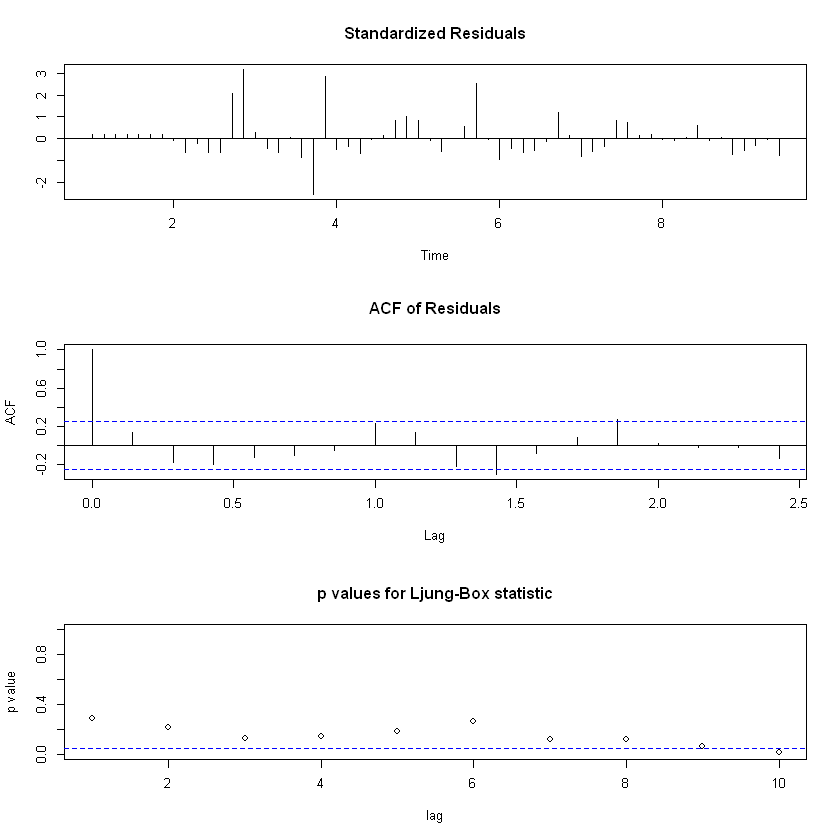

In [14]:
tsdiag(ARIMAfit)

El ACF aplicado a los residuos no presenta retrasos en los que las barras salgan de la zona de insignificancia y en el test Ljung-Box el p-valor es superior al 0.05 por lo que no se rechaza la hipotesis de la distribución de los residuos como ruido blanco.

<h4>Paso 4: Predicción</h4>

Ver la data resultante de la predicción.

In [15]:
par(mfrow = c(1,1))
pred = forecast(ARIMAfit, h = 30)
pred

          Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
 9.571429       11.23386 11.15079 11.31693 11.10681 11.36091
 9.714286       11.49436 11.41128 11.57743 11.36731 11.62140
 9.857143       11.54833 11.46526 11.63141 11.42129 11.67538
10.000000       11.54565 11.46258 11.62873 11.41861 11.67270
10.142857       11.54000 11.45692 11.62307 11.41295 11.66704
10.285714       11.49056 11.40749 11.57363 11.36351 11.61761
10.428571       11.26258 11.17951 11.34565 11.13553 11.38963
10.571429       11.22899 11.14591 11.31206 11.10193 11.35604
10.714286       11.52044 11.43737 11.60352 11.39339 11.64749
10.857143       11.53782 11.45475 11.62090 11.41077 11.66487
11.000000       11.54475 11.46168 11.62782 11.41770 11.67180
11.142857       11.54470 11.46163 11.62778 11.41765 11.67175
11.285714       11.50431 11.42124 11.58739 11.37726 11.63136
11.428571       11.25310 11.17002 11.33617 11.12605 11.38015
11.571429       11.25900 11.16315 11.35486 11.11240 11.40561
11.714286       11.53272

Generar gráfica de la Serie Temporal y su predicción.

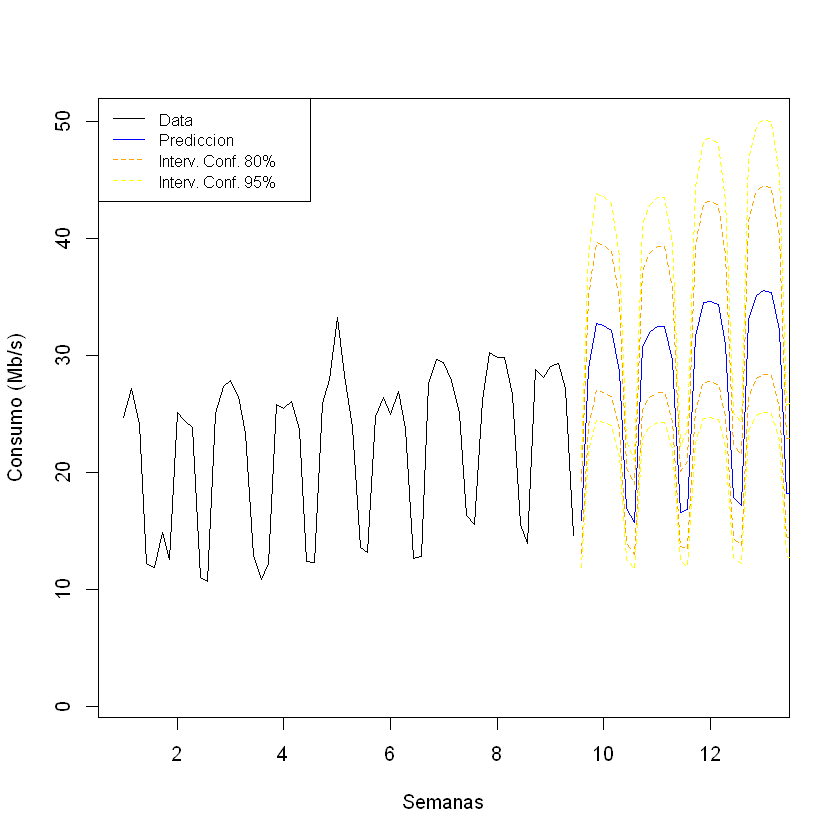

In [16]:
plot(datats/10800000000,type='l', xlim=c(1,13), ylim=c(1,50), xlab='Semanas', ylab='Consumo (Mb/s)')
lines((10^(pred$mean))/10800000000, col='blue')
lines((10^(pred$lower[,1]))/10800000000, lty=2, col='orange')
lines((10^(pred$lower[,2]))/10800000000, lty=2, col='yellow')
lines((10^(pred$upper[,1]))/10800000000, lty=2, col='orange')
lines((10^(pred$upper[,2]))/10800000000, lty=2, col='yellow')
legend("topleft", legend=c("Data", "Prediccion", "Interv. Conf. 80%", "Interv. Conf. 95%"), col=c("black", "blue", "orange", "yellow"), lty=c(1,1,2,2), cex=0.8)

Exportar la data resultante de la predicción.

In [17]:
pred_mean=10^(pred$mean)
pred_lower80=10^(pred$lower[,1])
pred_upper80=10^(pred$upper[,1])
pred_lower95=10^(pred$lower[,2])
pred_upper95=10^(pred$upper[,2])
canal_pred=data.frame(pred=as.matrix(pred_mean), lower80=as.matrix(pred_lower80), upper80=as.matrix(pred_upper80), lower95=as.matrix(pred_lower95), upper95=as.matrix(pred_upper95))
canal_pred=data.frame(week=round(time(pred_mean))+(round((time(pred_mean)-as.integer(time(pred_mean))+0.14286)/0.14286)/10), pred=as.matrix(pred_mean), lower80=as.matrix(pred_lower80), upper80=as.matrix(pred_upper80), lower95=as.matrix(pred_lower95), upper95=as.matrix(pred_upper95))
write.csv(canal_pred, file="canal_pred.csv", row.names=TRUE)